This notebook takes the combined run- and experiment-wide metrics of each sequence-charge, and builds a run-specific estimator for intensity delta.

X is a sequence's attributes in a run:
- log2 intensity
- uncalibrated m/z (the raw intensity as extracted by TFD)
- charge
- retention time
- CCS

y is the delta of intensity in a run from the median intensity of the sequence over the experiment.

For training, filter:
- human only
- only sequences detected in at least half the runs
- only 1to1 runs

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt

In [2]:
from sklearn import neighbors

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
# EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'

In [5]:
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features/extracted-features.sqlite".format(EXPERIMENT_DIR)
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)


In [6]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result


In [7]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,intensity,monoisotopic_mass,monoisotopic_mz_centroid,rt_apex,scan_apex,run_name,batch,human,number_of_runs_extracted from features where (rt_apex is not null) and (scan_apex is not null)', db_conn)
db_conn.close()


In [8]:
sequences_df['log_intensity'] = np.log2(sequences_df.intensity)

In [9]:
len(sequences_df)

532925

In [10]:
# find the experiment-wide means and std devs for m/z, CCS, RT
experiment_means_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    # intensity
    experiment_intensity_mean = np.mean(group_df.log_intensity)
    experiment_intensity_std_dev = np.std(group_df.log_intensity)
    # m/z
    experiment_mz_mean = np.mean(group_df.monoisotopic_mz_centroid)
    experiment_mz_std_dev = np.std(group_df.monoisotopic_mz_centroid)
    # rt
    experiment_rt_mean = np.mean(group_df.rt_apex)
    experiment_rt_std_dev = np.std(group_df.rt_apex)
    # scan
    experiment_scan_mean = np.mean(group_df.scan_apex)
    experiment_scan_std_dev = np.std(group_df.scan_apex)
    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    experiment_means_l.append((sequence,charge,experiment_intensity_mean,experiment_intensity_std_dev,experiment_mz_mean,experiment_mz_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev))

experiment_means_df = pd.DataFrame(experiment_means_l, columns=['sequence','charge','experiment_intensity_mean','experiment_intensity_std_dev','experiment_mz_mean','experiment_mz_std_dev','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev'])


In [11]:
sequences_df = pd.merge(sequences_df, experiment_means_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


#### Note that from now on we work with intensity and intensity delta in log2 space. The median is the median of log2(intensity).

In [12]:
sequences_df['delta_intensity'] = sequences_df.log_intensity - sequences_df.experiment_intensity_mean


In [13]:
run_name = '190719_Hela_Ecoli_1to1_01'
file_idx = file_idx_for_run(run_name)

In [14]:
minimum_number_of_runs_for_training_set = 10

In [15]:
# make the training set from human only, comprising sequences we have identified in a minimum of runs
high_frequency_human_sequences_df = sequences_df[(sequences_df.human == True) & (sequences_df.number_of_runs_extracted > minimum_number_of_runs_for_training_set)].copy()

proportion_to_subsample = 0.5
number_to_subsample = int(proportion_to_subsample * len(high_frequency_human_sequences_df))
training_set_all_runs_df = high_frequency_human_sequences_df.sample(n=number_to_subsample)
print("training set is {}% of all human sequences.".format(round(len(training_set_all_runs_df) / len(sequences_df[(sequences_df.human == True)]) * 100, 1)))

training set is 48.4% of all human sequences.


In [16]:
print("training set is {}% of the experiment.".format(round(len(training_set_all_runs_df) / len(sequences_df) * 100, 1)))

training set is 39.1% of the experiment.


In [17]:
training_set_selected_run_df = training_set_all_runs_df[training_set_all_runs_df.file_idx == file_idx]

In [18]:
training_set_selected_run_df.sample(5)

,sequence,charge,file_idx,intensity,monoisotopic_mass,monoisotopic_mz_centroid,rt_apex,scan_apex,run_name,batch,...,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_mz_mean,experiment_mz_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,delta_intensity
527200,YQAVQEAVEDR,2,11,901,1306.616376,654.315464,749.731943,722.0,190719_Hela_Ecoli_1to1_01,1to1,...,9.815383,9.599006,0.865938,654.314875,0.000687,776.149171,20.421669,715.200000,10.191173,0.216378
503829,VVAEEAWENHLK,2,11,1551,1423.710680,712.862616,490.485951,530.0,190719_Hela_Ecoli_1to1_01,1to1,...,10.598983,10.628685,0.550251,712.862348,0.000302,485.644920,4.364481,523.000000,5.540758,-0.029702
418615,SPYDGNETLLSPEK,2,11,1433,1548.732374,775.373463,536.846911,555.0,190719_Hela_Ecoli_1to1_01,1to1,...,10.484823,9.820675,1.531021,775.372746,0.000927,533.898987,14.309360,561.368421,10.022136,0.664148
13376,AFVDSGAQMTIMSQACAER,2,11,3642,2071.915487,1036.965020,712.027179,234.0,190719_Hela_Ecoli_1to1_01,1to1,...,11.830515,10.062852,1.595573,1036.964155,0.000763,699.609143,10.057528,222.700000,18.697861,1.767663
28599,ANPDPNCCLGVFGLSLYTTER,2,11,1140,2383.094253,1192.554403,956.841186,69.0,190719_Hela_Ecoli_1to1_01,1to1,...,10.154818,10.379659,0.681201,1192.554137,0.000370,951.360487,3.676950,68.733333,2.515728,-0.224841


In [19]:
len(training_set_selected_run_df)

10681

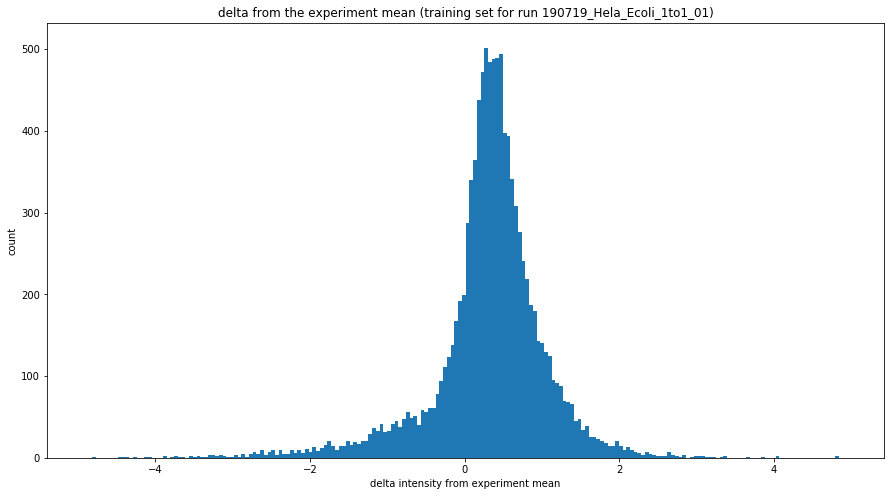

In [20]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 200
hist, bins, _ = plt.hist(training_set_selected_run_df.delta_intensity, bins=bins)
plt.xlabel('delta intensity from experiment mean')
plt.ylabel('count')
plt.title('delta from the experiment mean (training set for run {})'.format(run_name))

plt.show()

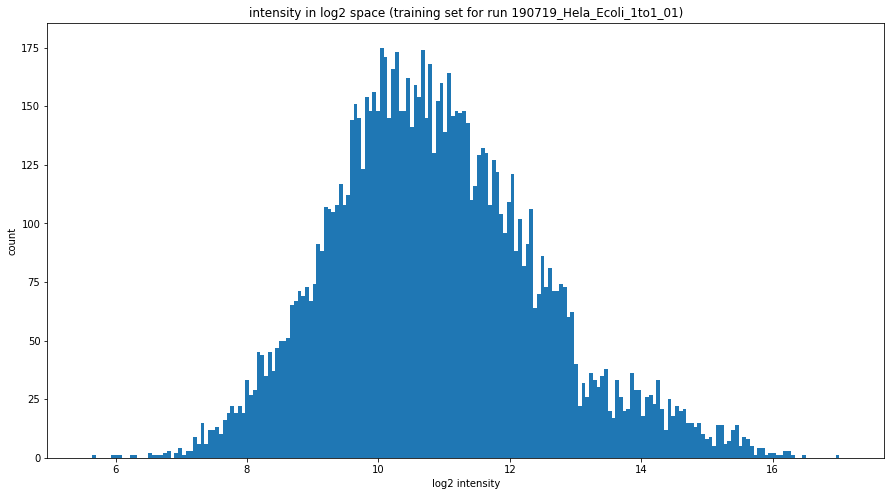

In [21]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 200
hist, bins, _ = plt.hist(training_set_selected_run_df.log_intensity, bins=bins)
plt.xlabel('log2 intensity')
plt.ylabel('count')
plt.title('intensity in log2 space (training set for run {})'.format(run_name))

plt.show()

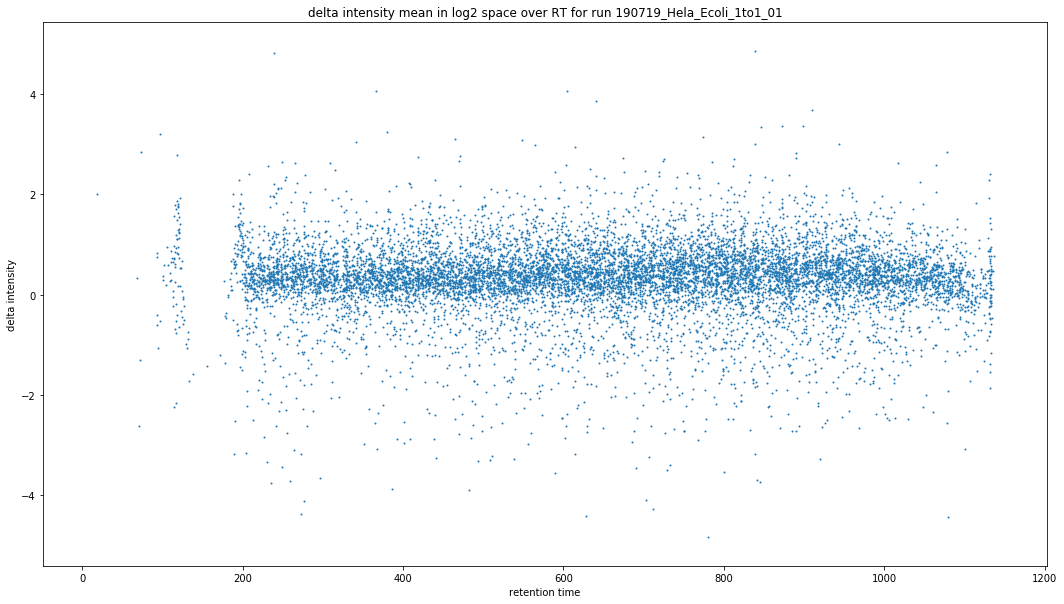

In [59]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(training_set_selected_run_df.rt_apex, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('retention time')
plt.title('delta intensity mean in log2 space over RT for run {}'.format(run_name))
# plt.xlim((300,400))
# plt.ylim((-2,2))

plt.show()

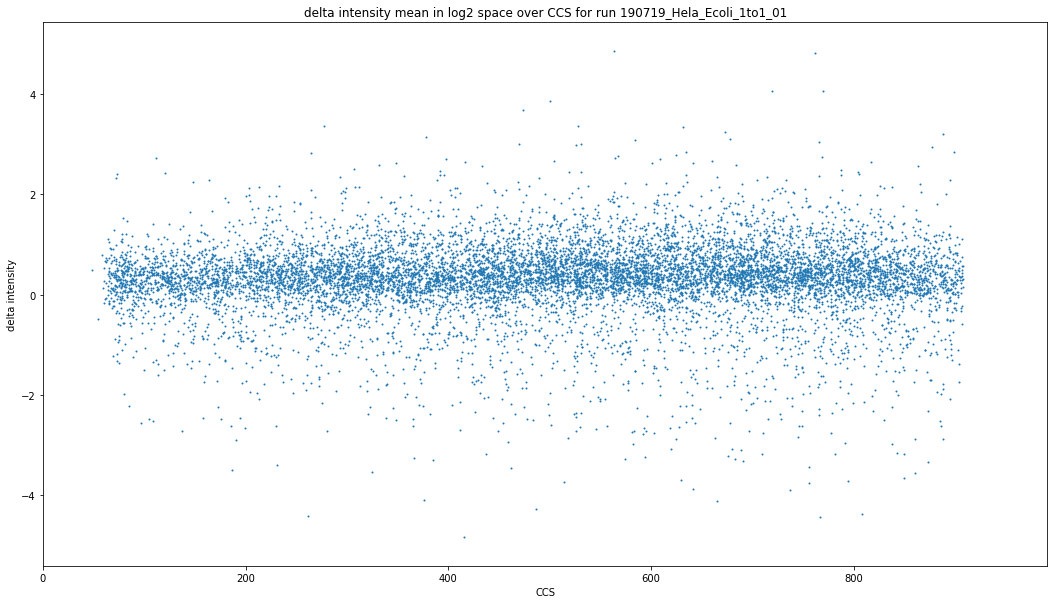

In [60]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(training_set_selected_run_df.scan_apex, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('CCS')
plt.title('delta intensity mean in log2 space over CCS for run {}'.format(run_name))
plt.xlim((0,991))
# plt.ylim((-2,2))

plt.show()

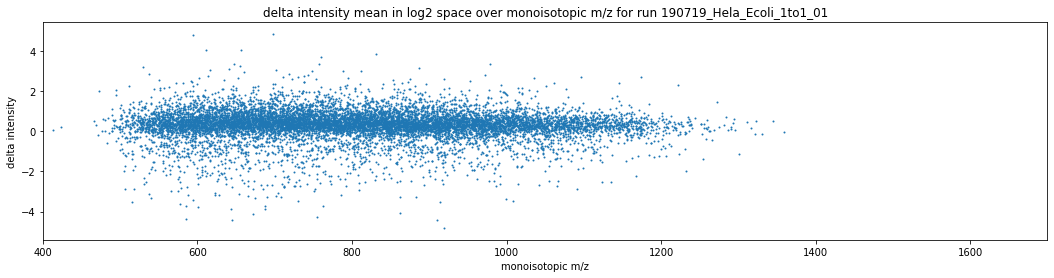

In [24]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)

ax.scatter(training_set_selected_run_df.monoisotopic_mz_centroid, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('monoisotopic m/z')
plt.title('delta intensity mean in log2 space over monoisotopic m/z for run {}'.format(run_name))
plt.xlim((400,1700))
# plt.ylim((-3,3))

plt.show()

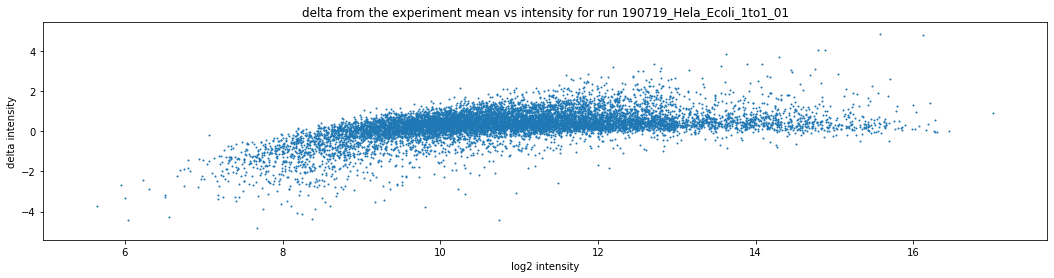

In [25]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)

ax.scatter(training_set_selected_run_df.log_intensity, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('log2 intensity')
plt.title('delta from the experiment mean vs intensity for run {}'.format(run_name))
# plt.xlim((400,1700))

plt.show()

#### use a kNN model to predict the effect on intensity of m/z, CCS, and RT

In [26]:
training_set_selected_run_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity', 'monoisotopic_mass',
       'monoisotopic_mz_centroid', 'rt_apex', 'scan_apex', 'run_name', 'batch',
       'human', 'number_of_runs_extracted', 'log_intensity',
       'experiment_intensity_mean', 'experiment_intensity_std_dev',
       'experiment_mz_mean', 'experiment_mz_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'delta_intensity'],
      dtype='object')

In [27]:
training_attributes = ['monoisotopic_mz_centroid','rt_apex','scan_apex']

In [28]:
# split the training set
X = training_set_selected_run_df[training_attributes].values
y = training_set_selected_run_df[['delta_intensity']].values[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [29]:
len(X_train), len(X_test)

(9612, 1069)

In [30]:
n_neighbors = 20
weights = 'distance'
knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)

In [31]:
# fit the model
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                    weights='distance')

In [32]:
# calculate the score
train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)
print("R-squared for training set: {}, test set: {}".format(round(train_score,1), round(test_score, 1)))

R-squared for training set: 1.0, test set: -0.0


#### train a model for each of the runs

In [33]:
mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)

In [34]:
for mapping in mapping_l:
    file_idx_for_this_model = mapping[0]
    
    # filter out rows we don't want in the training set for this run-specific model
    training_set_for_run_df = training_set_all_runs_df[(training_set_all_runs_df.file_idx == file_idx_for_this_model)]
    print("there are {} sequences in the training set for file {}".format(len(training_set_for_run_df), file_idx_for_this_model))

    # split the training set
    X = training_set_for_run_df[training_attributes].values
    y = training_set_for_run_df[['delta_intensity']].values[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # fit the model
    knn.fit(X_train, y_train)

    # save the trained model
    MODEL_FILE_NAME = '{}/intensity-models/file-{}-intensity-model.pkl'.format(EXPERIMENT_DIR, file_idx_for_this_model)
    with open(MODEL_FILE_NAME, 'wb') as file:
        pickle.dump(knn, file)


there are 10356 sequences in the training set for file 0
there are 10436 sequences in the training set for file 1
there are 10364 sequences in the training set for file 2
there are 10380 sequences in the training set for file 3
there are 10398 sequences in the training set for file 4
there are 10547 sequences in the training set for file 5
there are 10751 sequences in the training set for file 6
there are 10309 sequences in the training set for file 7
there are 10133 sequences in the training set for file 8
there are 10399 sequences in the training set for file 9
there are 10019 sequences in the training set for file 10
there are 10681 sequences in the training set for file 11
there are 10313 sequences in the training set for file 12
there are 9961 sequences in the training set for file 13
there are 10418 sequences in the training set for file 14
there are 10596 sequences in the training set for file 15
there are 10622 sequences in the training set for file 16
there are 10573 sequences

#### use the run-specific models to estimate the delta intensity for all sequences in all runs

In [35]:
normalised_intensities_l = []
for mapping in mapping_l:
    file_idx = mapping[0]
    print("file {}".format(file_idx))
    
    # load the model for this run
    MODEL_FILE_NAME = '{}/intensity-models/file-{}-intensity-model.pkl'.format(EXPERIMENT_DIR, file_idx)
    with open(MODEL_FILE_NAME, 'rb') as file:
        knn = pickle.load(file)
    
    # get the sequences in this run
    run_df = sequences_df[sequences_df.file_idx == file_idx].copy()
    
    # build the list of sequences for inference
    X = run_df[training_attributes].values

    # predict the log2 delta intensity for each sequence in the run
    y = knn.predict(X)
    
    run_df['estimated_delta_intensity'] = y
    run_df['normalised_log_intensity'] = run_df.log_intensity - y
    run_df['normalised_intensity'] = np.power(2, run_df.normalised_log_intensity)
    
    normalised_intensities_l.append(run_df[['sequence','charge','file_idx','estimated_delta_intensity','normalised_log_intensity','normalised_intensity']])

# make a single df from the list of dfs
normalised_intensities_df = pd.concat(normalised_intensities_l, axis=0, sort=False)

# add the normalised intensity columns with the sequences
sequences_df = pd.merge(sequences_df, normalised_intensities_df, how='left', left_on=['sequence','charge','file_idx'], right_on=['sequence','charge','file_idx'])


file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19


In [36]:
# did any gaps creep in?
sequences_df[sequences_df.isnull().any(axis=1)]

,sequence,charge,file_idx,intensity,monoisotopic_mass,monoisotopic_mz_centroid,rt_apex,scan_apex,run_name,batch,...,experiment_mz_mean,experiment_mz_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,delta_intensity,estimated_delta_intensity,normalised_log_intensity,normalised_intensity


In [37]:
sequences_human_1to1_df = sequences_df[(sequences_df.human == True) & (sequences_df.batch == '1to1')]
sequences_human_1to3_df = sequences_df[(sequences_df.human == True) & (sequences_df.batch == '1to3')]
sequences_ecoli_1to1_df = sequences_df[(sequences_df.human == False) & (sequences_df.batch == '1to1')]
sequences_ecoli_1to3_df = sequences_df[(sequences_df.human == False) & (sequences_df.batch == '1to3')]


#### plot the CVs before and after normalisation

In [38]:
sequence_cv_by_batch_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge','batch','human'], as_index=False):
    if len(group_df) > 1:
        sequence = group_name[0]
        charge = group_name[1]
        batch = group_name[2]
        human = group_name[3]
        intensity_cv_before_normalisation = np.std(group_df.intensity) / np.mean(group_df.intensity)
        intensity_cv_after_normalisation = np.std(group_df.normalised_intensity) / np.mean(group_df.normalised_intensity)
        sequence_cv_by_batch_l.append((sequence, charge, batch, human, intensity_cv_before_normalisation, intensity_cv_after_normalisation))
sequence_cv_groups_df = pd.DataFrame(sequence_cv_by_batch_l, columns=['sequence','charge','batch','human','intensity_cv_before_normalisation', 'intensity_cv_after_normalisation'])

In [39]:
sequence_cv_groups_df.sample(5)

,sequence,charge,batch,human,intensity_cv_before_normalisation,intensity_cv_after_normalisation
21622,GYSYDLEVEQAYDLAR,2,1to3,1,0.111825,0.203853
32688,LPVGTTATLYFR,2,1to3,1,0.872853,0.428725
48991,TFVHVVPAKPEGTFK,3,1to3,1,0.119547,0.139644
25967,INHGDNPLDASTVHPEAYPVVER,3,1to1,0,0.405110,0.425841
12784,EMEAELEDERK,2,1to1,1,0.123994,0.158743


In [40]:
human_1to1_df = sequence_cv_groups_df[(sequence_cv_groups_df.human == True) & (sequence_cv_groups_df.batch == '1to1')]
human_1to3_df = sequence_cv_groups_df[(sequence_cv_groups_df.human == True) & (sequence_cv_groups_df.batch == '1to3')]
ecoli_1to1_df = sequence_cv_groups_df[(sequence_cv_groups_df.human == False) & (sequence_cv_groups_df.batch == '1to1')]
ecoli_1to3_df = sequence_cv_groups_df[(sequence_cv_groups_df.human == False) & (sequence_cv_groups_df.batch == '1to3')]

#### both species on one plot

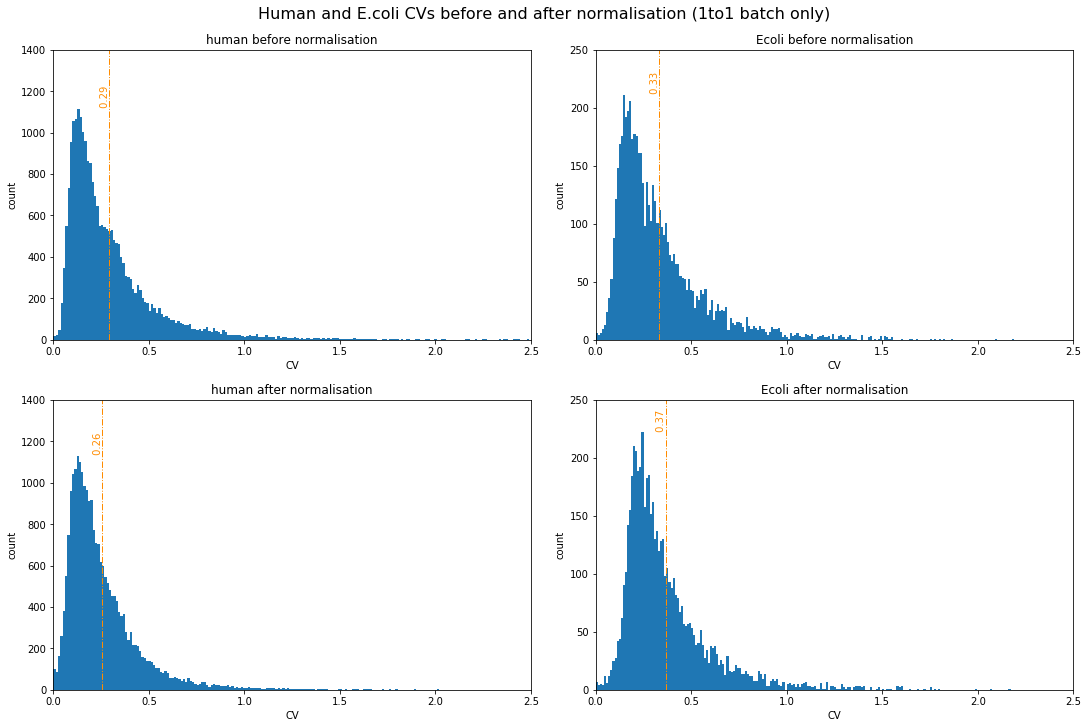

In [41]:
f, axarr = plt.subplots(nrows=2, ncols=2, constrained_layout=True)

f.set_figheight(10)
f.set_figwidth(15)
f.suptitle('Human and E.coli CVs before and after normalisation (1to1 batch only)', fontsize=16)

bins = 200
text_style = dict(size=10, color='darkorange')

# human before normalisation
ax = axarr[0,0]  # row, column
ax.set_title('human before normalisation')

values = human_1to1_df.intensity_cv_before_normalisation
y, x, _ = ax.hist(values, bins=bins)
mean = np.mean(values)
ax.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
ax.text(mean-0.05, y.max(), " {}".format(round(mean,2)), **text_style, rotation=90)

ax.set_xlabel('CV')
ax.set_ylabel('count')
ax.set_xlim((0,2.5))
ax.set_ylim((0,1400))

# human after normalisation
ax = axarr[1,0]  # row, column
ax.set_title('human after normalisation')

values = human_1to1_df.intensity_cv_after_normalisation
y, x, _ = ax.hist(values, bins=bins)
mean = np.mean(values)
ax.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
ax.text(mean-0.05, y.max(), " {}".format(round(mean,2)), **text_style, rotation=90)

ax.set_xlabel('CV')
ax.set_ylabel('count')
ax.set_xlim((0,2.5))
ax.set_ylim((0,1400))

# E.coli before normalisation
ax = axarr[0,1]  # row, column
ax.set_title('Ecoli before normalisation')

values = ecoli_1to1_df.intensity_cv_before_normalisation
y, x, _ = ax.hist(values, bins=bins)
mean = np.mean(values)
ax.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
ax.text(mean-0.05, y.max(), " {}".format(round(mean,2)), **text_style, rotation=90)

ax.set_xlabel('CV')
ax.set_ylabel('count')
ax.set_xlim((0,2.5))
ax.set_ylim((0,250))

# E.coli after normalisation
ax = axarr[1,1]  # row, column
ax.set_title('Ecoli after normalisation')

values = ecoli_1to1_df.intensity_cv_after_normalisation
y, x, _ = ax.hist(values, bins=bins)
mean = np.mean(values)
ax.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
ax.text(mean-0.05, y.max(), " {}".format(round(mean,2)), **text_style, rotation=90)

ax.set_xlabel('CV')
ax.set_ylabel('count')
ax.set_xlim((0,2.5))
ax.set_ylim((0,250))

plt.show()

#### plot the CV between runs

In [42]:
run_name_A = '190719_Hela_Ecoli_1to1_01'
run_file_idx_A = file_idx_for_run(run_name_A)

run_name_B = '190719_Hela_Ecoli_1to1_02'
run_file_idx_B = file_idx_for_run(run_name_B)

run_name_C = '190719_Hela_Ecoli_1to1_03'
run_file_idx_C = file_idx_for_run(run_name_C)

In [43]:
three_runs_df = sequences_df[sequences_df.file_idx.isin([run_file_idx_A,run_file_idx_B,run_file_idx_C])]

In [44]:
sequence_cv_l = []
for group_name,group_df in three_runs_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    if len(group_df.file_idx.unique()) == 3:  # if the sequence is in all three runs
        intensity_cv_before_normalisation = np.std(group_df.intensity) / np.mean(group_df.intensity)
        intensity_cv_after_normalisation = np.std(group_df.normalised_intensity) / np.mean(group_df.normalised_intensity)
        sequence_cv_l.append((sequence, charge, intensity_cv_before_normalisation, intensity_cv_after_normalisation))
sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv_before_normalisation','intensity_cv_after_normalisation'])


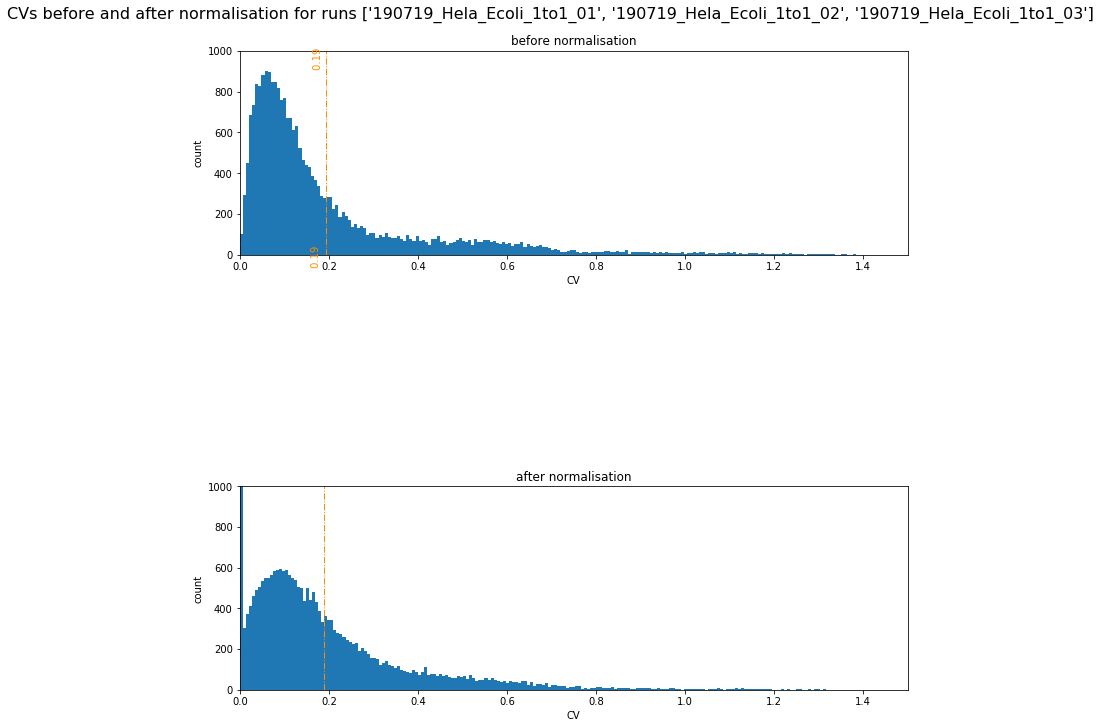

In [45]:
f, axarr = plt.subplots(nrows=2, ncols=1, constrained_layout=True)

f.set_figheight(10)
f.set_figwidth(10)
f.suptitle('CVs before and after normalisation for runs {}'.format([run_name_A,run_name_B,run_name_C]), fontsize=16)

bins = 200
text_style = dict(size=10, color='darkorange')

ax = axarr[0]
ax.set_title('before normalisation')

values = sequence_cv_df.intensity_cv_before_normalisation
y, x, _ = ax.hist(values, bins=bins)
mean = np.mean(values)
ax.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
ax.text(mean-0.03, y.max(), " {}".format(round(mean,2)), **text_style, rotation=90)

ax.set_xlabel('CV')
ax.set_ylabel('count')
ax.set_xlim((0,1.5))
ax.set_ylim((0,1000))

ax = axarr[1]
ax.set_title('after normalisation')

values = sequence_cv_df.intensity_cv_after_normalisation
y, x, _ = ax.hist(values, bins=bins)
mean = np.mean(values)
ax.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
ax.text(mean-0.03, y.max(), " {}".format(round(mean,2)), **text_style, rotation=90)

ax.set_xlabel('CV')
ax.set_ylabel('count')
ax.set_xlim((0,1.5))
ax.set_ylim((0,1000))

plt.show()

#### plot the delta intensity between run 01 and 02

In [46]:
run_name_A = '190719_Hela_Ecoli_1to1_01'
run_file_idx_A = file_idx_for_run(run_name_A)

run_name_B = '190719_Hela_Ecoli_1to1_02'
run_file_idx_B = file_idx_for_run(run_name_B)


In [47]:
runs_AB_df = sequences_df[sequences_df.file_idx.isin([run_file_idx_A,run_file_idx_B])]

In [48]:
sequence_intensity_delta_l = []
for group_name,group_df in runs_AB_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    if len(group_df.file_idx.unique()) == 2:  # if the sequence is in both runs
        # intensity before normalisation
        intensity_A = group_df[group_df.file_idx == run_file_idx_A].iloc[0].intensity
        intensity_B = group_df[group_df.file_idx == run_file_idx_B].iloc[0].intensity
        intensity_delta_before_normalisation = intensity_A - intensity_B
        # intensity after normalisation
        normalised_intensity_A = group_df[group_df.file_idx == run_file_idx_A].iloc[0].normalised_intensity
        normalised_intensity_B = group_df[group_df.file_idx == run_file_idx_B].iloc[0].normalised_intensity
        intensity_delta_after_normalisation = normalised_intensity_A - normalised_intensity_B
        # apexes
        rt_apex = group_df.rt_apex.iloc[0]
        scan_apex = group_df.scan_apex.iloc[0]
        mz_apex = group_df.monoisotopic_mz_centroid.iloc[0]
        sequence_intensity_delta_l.append((sequence, charge, rt_apex, scan_apex, mz_apex, intensity_delta_before_normalisation, intensity_delta_after_normalisation))
sequence_intensity_delta_df = pd.DataFrame(sequence_intensity_delta_l, columns=['sequence','charge','rt_apex','scan_apex','mz_apex','intensity_delta_before_normalisation','intensity_delta_after_normalisation'])


In [49]:
sequence_intensity_delta_df.sample(n=5)

,sequence,charge,rt_apex,scan_apex,mz_apex,intensity_delta_before_normalisation,intensity_delta_after_normalisation
20392,TANDMIHAENMR,2,349.601546,634.0,701.815637,11799,7057.679226
827,AHPSLTLHQDPVYVTR,3,497.960508,821.0,611.991771,-702,-464.246674
24747,YLHENQIVHR,2,380.345755,638.0,654.844061,2173,8330.343796
7664,GECQTTIQGQAR,2,216.859333,692.0,674.818072,-514,-95.672145
20277,SYEAQDPEIASLSGK,2,521.905128,517.0,797.885496,-29033,-13870.426824


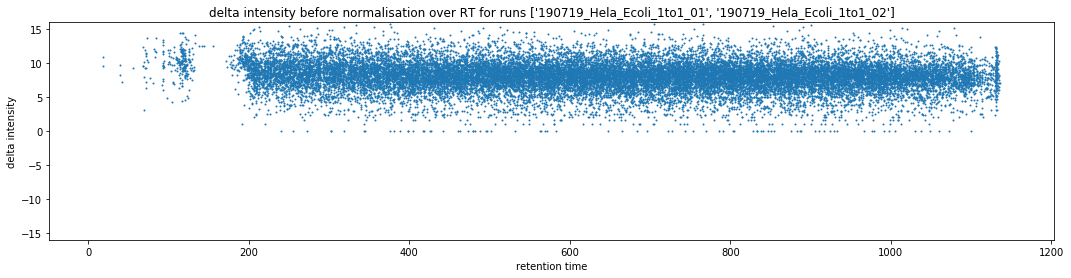

In [50]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

sequence_intensity_delta_df.intensity_delta_before_normalisation.replace(to_replace=0, value=1, inplace=True)
log_delta = np.log2(np.abs(sequence_intensity_delta_df.intensity_delta_before_normalisation))
ax.scatter(sequence_intensity_delta_df.rt_apex, log_delta, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('retention time')
plt.title('delta intensity before normalisation over RT for runs {}'.format([run_name_A,run_name_B]))
# plt.xlim((0,991))
plt.ylim((-16,16))

plt.show()

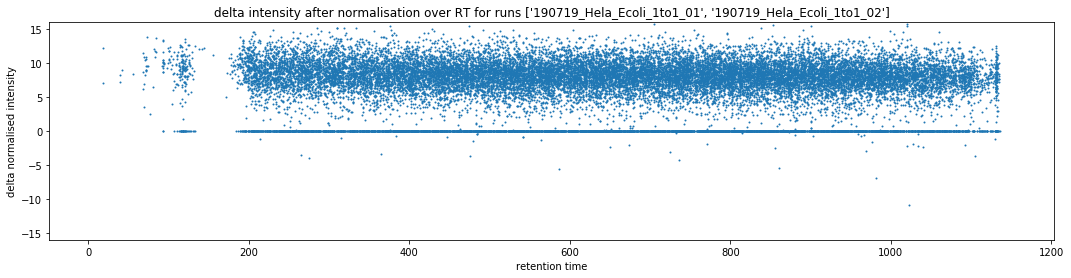

In [51]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

sequence_intensity_delta_df.intensity_delta_after_normalisation.replace(to_replace=0, value=1, inplace=True)
log_delta = np.log2(np.abs(sequence_intensity_delta_df.intensity_delta_after_normalisation))
ax.scatter(sequence_intensity_delta_df.rt_apex, log_delta, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta normalised intensity')
plt.xlabel('retention time')
plt.title('delta intensity after normalisation over RT for runs {}'.format([run_name_A,run_name_B]))
# plt.xlim((0,991))
plt.ylim((-16,16))

plt.show()

#### did we lose the separation between human and Ecoli?

In [52]:
NUMBER_OF_1TO1_RUNS = 10
NUMBER_OF_1TO3_RUNS = 10

In [53]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= int(NUMBER_OF_1TO1_RUNS / 2)) and (len(sequence_in_1to3_df) >= int(NUMBER_OF_1TO3_RUNS / 2)):
        average_intensity_in_1to1 = sequence_in_1to1_df.normalised_log_intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.normalised_log_intensity.mean()
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))

In [54]:
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [55]:
# sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 / sequence_occurences_in_batch_df.intensity_1to1
sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 - sequence_occurences_in_batch_df.intensity_1to1


In [56]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

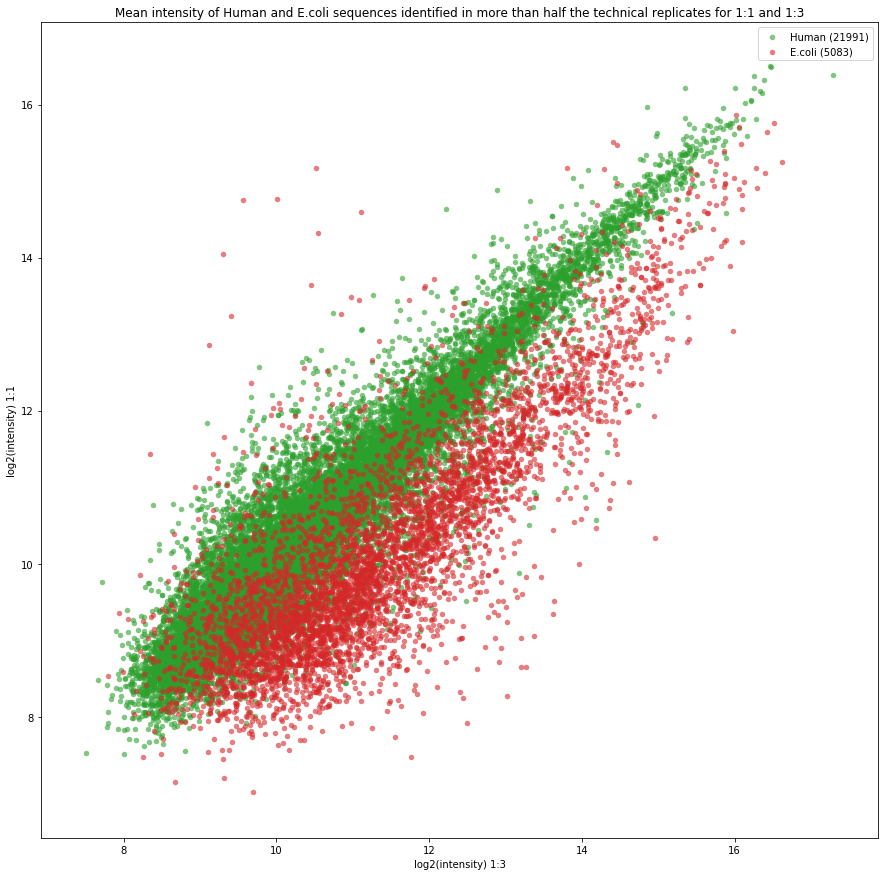

In [57]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(human_df.intensity_1to3, human_df.intensity_1to1, marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(ecoli_df.intensity_1to3, ecoli_df.intensity_1to1, marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

# plt.xlim((4,17))
# plt.ylim((4,17))

plt.show()

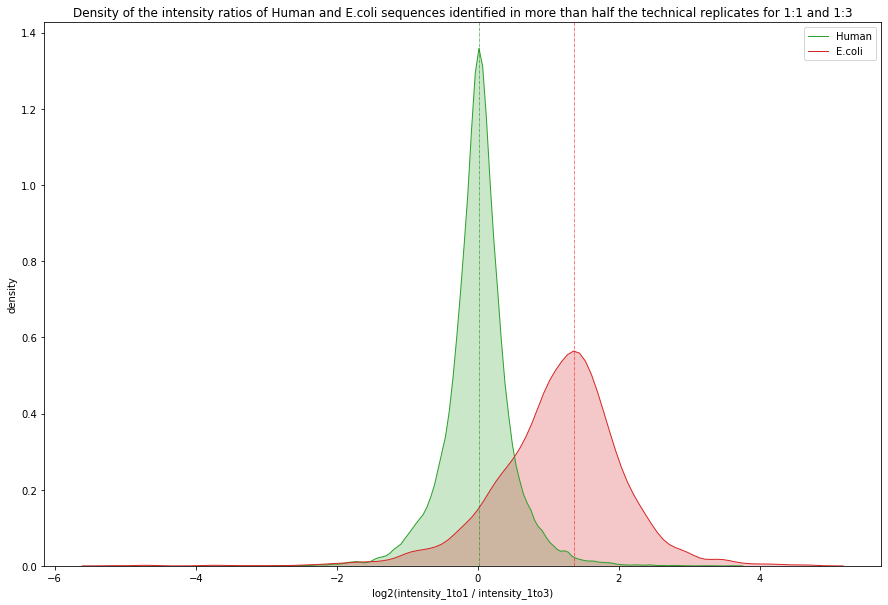

In [58]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(human_df['intensity_ratio'], hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(ecoli_df['intensity_ratio'], hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')